In [3]:
%cd ~/REVIVAL2

/disk2/fli/REVIVAL2


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# vis based on different metrics 
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import warnings

from REVIVAL.util import ndcg, ndcg_scale, custom_ndcg, calc_top_n_percent_recall, get_file_name

# Suppress only ConstantInputWarning
warnings.simplefilter("ignore", category=UserWarning)


/disk2/fli/miniconda3/envs/REVIVAL/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [29]:
parlq_df = pd.read_csv("/disk2/fli/REVIVAL2/zs/comb/ParLQ.csv")
parlq_df

,AAs,var,fitness,selectivity,n_mut,enzyme,hd,AA1,AA2,AA3,...,vina_max_chai-score_joint-substrate_cofactor-docked,vina_chai-score_joint-substrate+carbene_cofactor-docked,vina_min_chai-score_joint-substrate+carbene_cofactor-docked,vina_max_chai-score_joint-substrate+carbene_cofactor-docked,vina_chai-score_joint-substrate_cofactor-score_only,vina_min_chai-score_joint-substrate_cofactor-score_only,vina_max_chai-score_joint-substrate_cofactor-score_only,vina_chai-score_joint-substrate+carbene_cofactor-score_only,vina_min_chai-score_joint-substrate+carbene_cofactor-score_only,vina_max_chai-score_joint-substrate+carbene_cofactor-score_only
0,WYLQA,F89A,0.000000,0.000000,1,ParLQ,-1,W,Y,L,...,-3.848,-8.5214,-9.536,-6.633,3.9152,-4.927,14.588,5.7420,-2.362,15.466
1,WYLQC,F89C,4.215013,0.174286,1,ParLQ,-1,W,Y,L,...,-5.217,-9.2284,-9.626,-8.817,-3.3796,-4.345,-1.802,-1.6322,-2.802,0.180
2,WYLQD,F89D,1.585337,0.025801,1,ParLQ,-1,W,Y,L,...,-3.897,-8.7944,-9.675,-7.589,6.3478,-3.642,15.122,8.3438,-0.670,15.730
3,WYLQE,F89E,2.487884,0.090939,1,ParLQ,-1,W,Y,L,...,-3.580,-8.1112,-9.529,-6.378,1.3006,-1.239,3.965,4.8678,2.837,7.448
4,WYLQG,F89G,0.000000,0.000000,1,ParLQ,-1,W,Y,L,...,-4.556,-8.5296,-9.476,-7.296,-4.0322,-5.764,-2.030,-1.4432,-4.318,0.829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,WRLQF,Y57R,5.120007,0.266769,1,ParLQ,-1,W,R,L,...,-5.521,-9.0042,-9.732,-8.037,-3.0130,-4.280,-0.959,-0.7226,-2.627,2.231
486,WSLQF,Y57S,14.675230,0.422914,1,ParLQ,-1,W,S,L,...,-4.482,-8.8588,-10.230,-7.530,-3.2056,-4.327,-2.253,-0.9008,-2.081,0.845
487,WTLQF,Y57T,13.030966,0.373729,1,ParLQ,-1,W,T,L,...,-5.810,-8.5750,-9.706,-7.002,-4.1596,-5.182,-3.531,-1.3030,-3.116,1.201
488,WVLQF,Y57V,12.362720,0.310562,1,ParLQ,-1,W,V,L,...,-5.942,-8.7920,-9.415,-8.137,-1.0820,-5.278,2.115,1.5004,-3.556,5.044


In [30]:
[c for c in parlq_df.columns if "_vol" in c]

['var_vol', 'substrate_vol', 'cofactor_vol', 'joint_vol']

In [36]:
spearmanr(np.array(parlq_df["joint_vol"]), np.array(parlq_df["substrate_vol"]) + np.array(parlq_df["cofactor_vol"]))

/tmp/ipykernel_358694/2771311539.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmanr(np.array(parlq_df["joint_vol"]), np.array(parlq_df["substrate_vol"]) + np.array(parlq_df["cofactor_vol"]))


SignificanceResult(statistic=nan, pvalue=nan)

In [6]:
rho_list = []
ndcg_list = []
top10_list = []
top25_list = []
top50_list = []

for f in glob("/disk2/fli/REVIVAL2/zs/comb/*.csv"):
    df_original = pd.read_csv(f)
    df_original = df_original[df_original.select_dtypes(include=['number']).columns]
    df_name = get_file_name(f)
    print(df_name)
    
    rho_dict = {"lib": df_name}
    ndcg_dict = {"lib": df_name}
    top10_dict = {"lib": df_name}
    top25_dict = {"lib": df_name}
    top50_dict = {"lib": df_name}
    
    for c in df_original.columns:
        if c == "fitness" or "_rank" in c:
            continue
        # check if nan is in the column, if so print out the rows with nan
        if df_original[c].isna().sum() > 0:
            print(c)
            print(len(df_original[df_original[c].isna()]))
        # now slice out the rows without nan
        df = df_original[df_original[c].notna()]
        if len(df) == 0:
            rho_dict[c] = np.nan
            ndcg_dict[c] = np.nan
            top10_dict[c] = np.nan
            top25_dict[c] = np.nan
            top50_dict[c] = np.nan
        
        else:

            y_true = df["fitness"].values
            y_score = df[c].values

            if "Triad_score" in c or "chain_pae_min" in c or "sum_" in c or "naive_score" in c:
                y_score = -1 * y_score
            if np.all(y_score == y_score[0]):  # Check if all values are identical
                rho_dict[c] = np.nan  # Assign NaN or 0 if needed
            else:
                rho_dict[c] = spearmanr(y_true, y_score).correlation
            ndcg_dict[c] = ndcg_scale(y_true=y_true, y_pred=y_score)
            top10_dict[c] = calc_top_n_percent_recall(y_true=y_true, y_score=y_score, top_n=10)
            top25_dict[c] = calc_top_n_percent_recall(y_true=y_true, y_score=y_score, top_n=25)
            top50_dict[c] = calc_top_n_percent_recall(y_true=y_true, y_score=y_score, top_n=50)

    rho_list.append(rho_dict)
    ndcg_list.append(ndcg_dict)
    top10_list.append(top10_dict)
    top25_list.append(top25_dict)
    top50_list.append(top50_dict)

df_rho = pd.DataFrame(rho_list)
df_ndcg = pd.DataFrame(ndcg_list)
df_top10 = pd.DataFrame(top10_list)
df_top25 = pd.DataFrame(top25_list)
df_top50 = pd.DataFrame(top50_list)

ParLQ
vina_af3-score_seperate-substrate_cofactor-score_only
4
vina_min_af3-score_seperate-substrate_cofactor-score_only
4
vina_max_af3-score_seperate-substrate_cofactor-score_only
4
vina_af3-score_seperate-substrate+carbene_cofactor-score_only
4
vina_min_af3-score_seperate-substrate+carbene_cofactor-score_only
4
vina_max_af3-score_seperate-substrate+carbene_cofactor-score_only
4
vina_af3-score_joint-substrate_cofactor-score_only
10
vina_min_af3-score_joint-substrate_cofactor-score_only
10
vina_max_af3-score_joint-substrate_cofactor-score_only
10
vina_af3-score_joint-substrate+carbene_cofactor-score_only
10
vina_min_af3-score_joint-substrate+carbene_cofactor-score_only
10
vina_max_af3-score_joint-substrate+carbene_cofactor-score_only
10
vina_chai-score_seperate-substrate_cofactor-docked
8
vina_min_chai-score_seperate-substrate_cofactor-docked
8
vina_max_chai-score_seperate-substrate_cofactor-docked
8
vina_chai-score_seperate-substrate_cofactor-score_only
9
vina_min_chai-score_seperate-s

In [11]:
df_rho

,lib,selectivity,n_mut,hd,ev_score,esm_score,flowsite_score,flowsite_std,ligandmpnn_score,var_vol,...,0:C-Si_agg_af3-struct_joint,0:C-Si_avg_af3-struct_joint,0:C-Si_std_af3-struct_joint,0:C-Si_agg_af3-struct_seperate,0:C-Si_avg_af3-struct_seperate,0:C-Si_std_af3-struct_seperate,0:C-Si_avg_chai-struct_joint,0:C-Si_std_chai-struct_joint,0:C-Si_avg_chai-struct_seperate,0:C-Si_std_chai-struct_seperate
0,ParLQ,0.961007,0.231575,-0.231575,0.064764,-0.016563,0.149739,0.767178,0.102997,-0.261154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PfTrpB-5iodo,NaN,-0.268085,0.268085,0.419296,0.479928,0.426583,0.234349,0.428536,0.137772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PfTrpB-5bromo,NaN,-0.331510,0.331510,0.487423,0.523450,0.404282,0.289631,0.462262,0.025118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PfTrpB-5cyano,NaN,-0.301809,0.301809,0.396476,0.425708,0.382270,0.268198,0.440015,-0.042512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PfTrpB-56chloro,NaN,-0.318860,0.318860,0.388337,0.461043,0.316607,0.348094,0.445602,-0.028684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PfTrpB-6chloro,NaN,-0.417893,0.417893,0.569694,0.612678,0.457337,0.241263,0.576349,-0.055604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Rma-CB,0.643717,-0.061590,0.061590,0.241046,0.214661,0.118630,-0.080166,0.260575,0.214222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Rma-CSi,0.455375,-0.039558,0.039558,0.117369,0.162468,-0.008253,-0.218604,0.123856,0.150916,...,0.055088,0.24732,-0.093355,0.078906,0.176156,0.110149,-0.011572,0.09156,-0.104207,-0.087255
8,PfTrpB-4cyano,NaN,-0.234953,0.234953,0.329215,0.352757,0.414012,0.121238,0.356667,-0.021313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PfTrpB-4bromo,NaN,-0.371285,0.371285,0.474594,0.478416,0.415240,0.212191,0.522690,-0.177474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
for c in df_rho.columns:
    if "std" not in c:
        print(c)

lib
selectivity
n_mut
hd
ev_score
esm_score
flowsite_score
ligandmpnn_score
var_vol
substrate_vol
cofactor_vol
joint_vol
var-substrate_vol
var-cofactor_vol
var-joint_vol
esmif_score_apo-score
esmif_score_docked-score
coves_score_apo_clean-output-100_processed
coves_score_sub_clean-output-100_processed
Triad_score_score-frompdb-cleanup
Triad_score_score-docked
ranking_score_agg_score_seperate_af3
mean_site_score_agg_score_seperate_af3
ptm_agg_score_seperate_af3
iptm_agg_score_seperate_af3
fraction_disordered_agg_score_seperate_af3
chain_ptm_A_agg_score_seperate_af3
chain_iptm_A_agg_score_seperate_af3
chain_pae_min_AA_agg_score_seperate_af3
chain_pae_min_AB_agg_score_seperate_af3
chain_iptm_AB_agg_score_seperate_af3
chain_pae_min_AC_agg_score_seperate_af3
chain_iptm_AC_agg_score_seperate_af3
chain_ptm_B_agg_score_seperate_af3
chain_iptm_B_agg_score_seperate_af3
chain_pae_min_BA_agg_score_seperate_af3
chain_iptm_BA_agg_score_seperate_af3
chain_pae_min_BB_agg_score_seperate_af3
chain_pae_m

In [60]:
df_rho

,lib,selectivity,n_mut,hd,ev_score,esm_score,flowsite_score,flowsite_std,ligandmpnn_score,var_vol,...,0:C-Si_agg_af3-struct_joint,0:C-Si_avg_af3-struct_joint,0:C-Si_std_af3-struct_joint,0:C-Si_agg_af3-struct_seperate,0:C-Si_avg_af3-struct_seperate,0:C-Si_std_af3-struct_seperate,0:C-Si_avg_chai-struct_joint,0:C-Si_std_chai-struct_joint,0:C-Si_avg_chai-struct_seperate,0:C-Si_std_chai-struct_seperate
0,ParLQ,0.961007,0.231575,-0.231575,0.064764,-0.016563,0.149739,0.767178,0.102997,-0.261154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PfTrpB-5iodo,NaN,-0.268085,0.268085,0.419296,0.479928,0.426583,0.234349,0.428536,0.137772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PfTrpB-5bromo,NaN,-0.331510,0.331510,0.487423,0.523450,0.404282,0.289631,0.462262,0.025118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PfTrpB-5cyano,NaN,-0.301809,0.301809,0.396476,0.425708,0.382270,0.268198,0.440015,-0.042512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PfTrpB-56chloro,NaN,-0.318860,0.318860,0.388337,0.461043,0.316607,0.348094,0.445602,-0.028684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PfTrpB-6chloro,NaN,-0.417893,0.417893,0.569694,0.612678,0.457337,0.241263,0.576349,-0.055604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Rma-CB,0.643717,-0.061590,0.061590,0.241046,0.214661,0.118630,-0.080166,0.260575,0.214222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Rma-CSi,0.455375,-0.039558,0.039558,0.117369,0.162468,-0.008253,-0.218604,0.123856,0.150916,...,0.055088,0.24732,-0.093355,0.078906,0.176156,0.110149,-0.011572,0.09156,-0.104207,-0.087255
8,PfTrpB-4cyano,NaN,-0.234953,0.234953,0.329215,0.352757,0.414012,0.121238,0.356667,-0.021313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PfTrpB-4bromo,NaN,-0.371285,0.371285,0.474594,0.478416,0.415240,0.212191,0.522690,-0.177474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
custom_order = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ",
]
# substrate
# 7iodo       0.605263
# 7methyl     0.605263
# 7bromo      0.605263
# 5iodo       0.600000
# 5bromo      0.600000
# 5chloro     0.600000
# 4bromo      0.550000
# 6chloro     0.536585
# 5cyano      0.489796
# 4cyano      0.489362
# 56chloro    0.333333
# Name: Atom Pair, dtype: float64

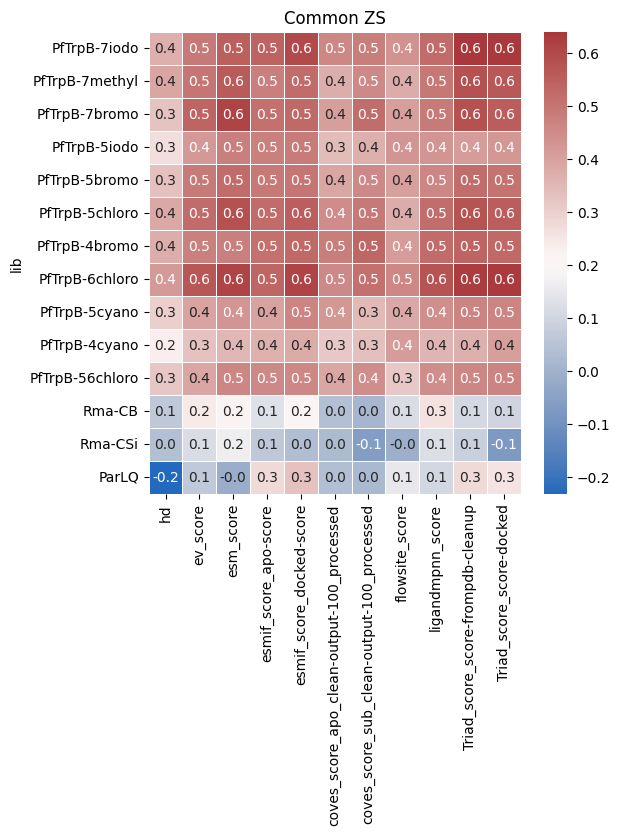

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame (Replace with your DataFrame)

common_zs = df_rho[
    [
        "lib",
        "hd",
        "ev_score",
        "esm_score",
        "esmif_score_apo-score",
        "esmif_score_docked-score",
        "coves_score_apo_clean-output-100_processed",
        "coves_score_sub_clean-output-100_processed",
        "flowsite_score",
        "ligandmpnn_score",
        "Triad_score_score-frompdb-cleanup",
        "Triad_score_score-docked",
    ]
].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(6, 6))

# Create a heatmap
sns.heatmap(common_zs, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Common ZS")
plt.show()

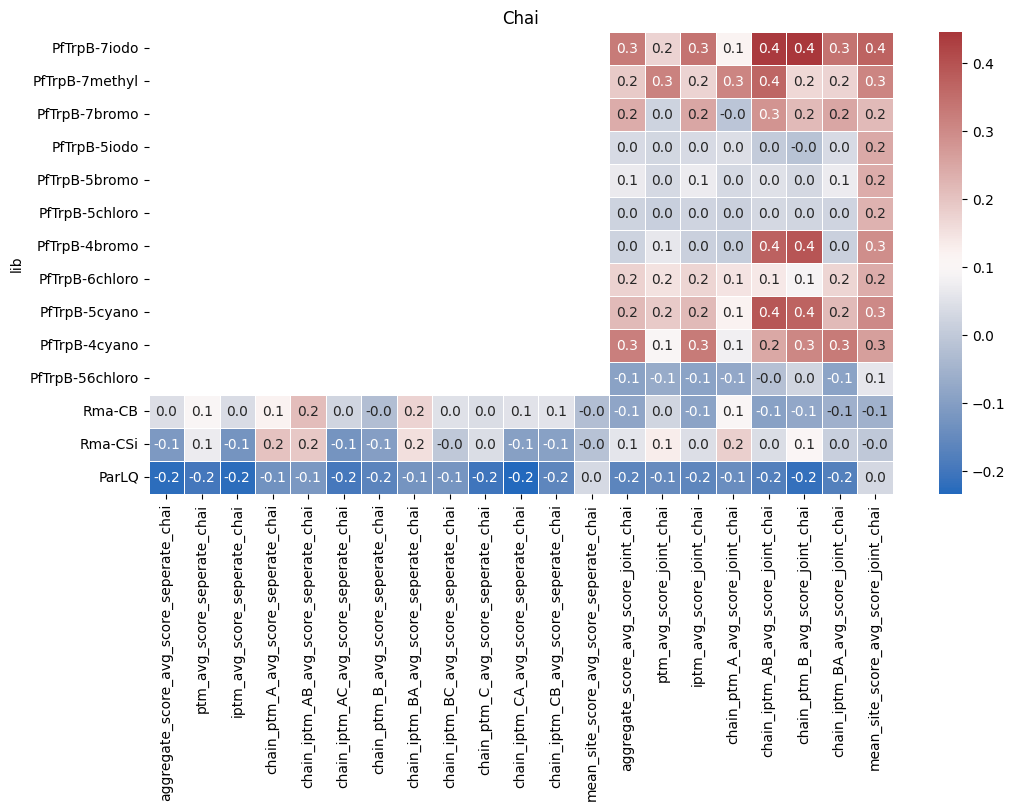

In [114]:
chai_df = (
    df_rho[
        [
            "lib",
            "aggregate_score_avg_score_seperate_chai",
            "ptm_avg_score_seperate_chai",
            "iptm_avg_score_seperate_chai",
            "chain_ptm_A_avg_score_seperate_chai",
            "chain_iptm_AB_avg_score_seperate_chai",
            "chain_iptm_AC_avg_score_seperate_chai",
            "chain_ptm_B_avg_score_seperate_chai",
            "chain_iptm_BA_avg_score_seperate_chai",
            "chain_iptm_BC_avg_score_seperate_chai",
            "chain_ptm_C_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CB_avg_score_seperate_chai",
            "mean_site_score_avg_score_seperate_chai",
            "aggregate_score_avg_score_joint_chai",
            "ptm_avg_score_joint_chai",
            "iptm_avg_score_joint_chai",
            "chain_ptm_A_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_ptm_B_avg_score_joint_chai",
            "chain_iptm_BA_avg_score_joint_chai",
            "mean_site_score_avg_score_joint_chai",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a heatmap
sns.heatmap(chai_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Chai")
plt.show()

In [95]:
chai_df.mean().sort_values(ascending=False)

mean_site_score_avg_score_joint_chai       0.195523
chain_iptm_AB_avg_score_joint_chai         0.147932
chain_ptm_B_avg_score_joint_chai           0.133046
chain_iptm_AB_avg_score_seperate_chai      0.095471
aggregate_score_avg_score_joint_chai       0.095056
iptm_avg_score_joint_chai                  0.094393
chain_iptm_BA_avg_score_joint_chai         0.093071
ptm_avg_score_joint_chai                   0.072293
chain_iptm_BA_avg_score_seperate_chai      0.067171
chain_ptm_A_avg_score_joint_chai           0.065338
chain_ptm_A_avg_score_seperate_chai        0.063746
mean_site_score_avg_score_seperate_chai   -0.003843
ptm_avg_score_seperate_chai               -0.009529
chain_iptm_BC_avg_score_seperate_chai     -0.027076
chain_ptm_C_avg_score_seperate_chai       -0.040655
chain_iptm_CB_avg_score_seperate_chai     -0.067363
chain_iptm_CA_avg_score_seperate_chai     -0.093518
chain_ptm_B_avg_score_seperate_chai       -0.098036
aggregate_score_avg_score_seperate_chai   -0.098568
chain_iptm_A

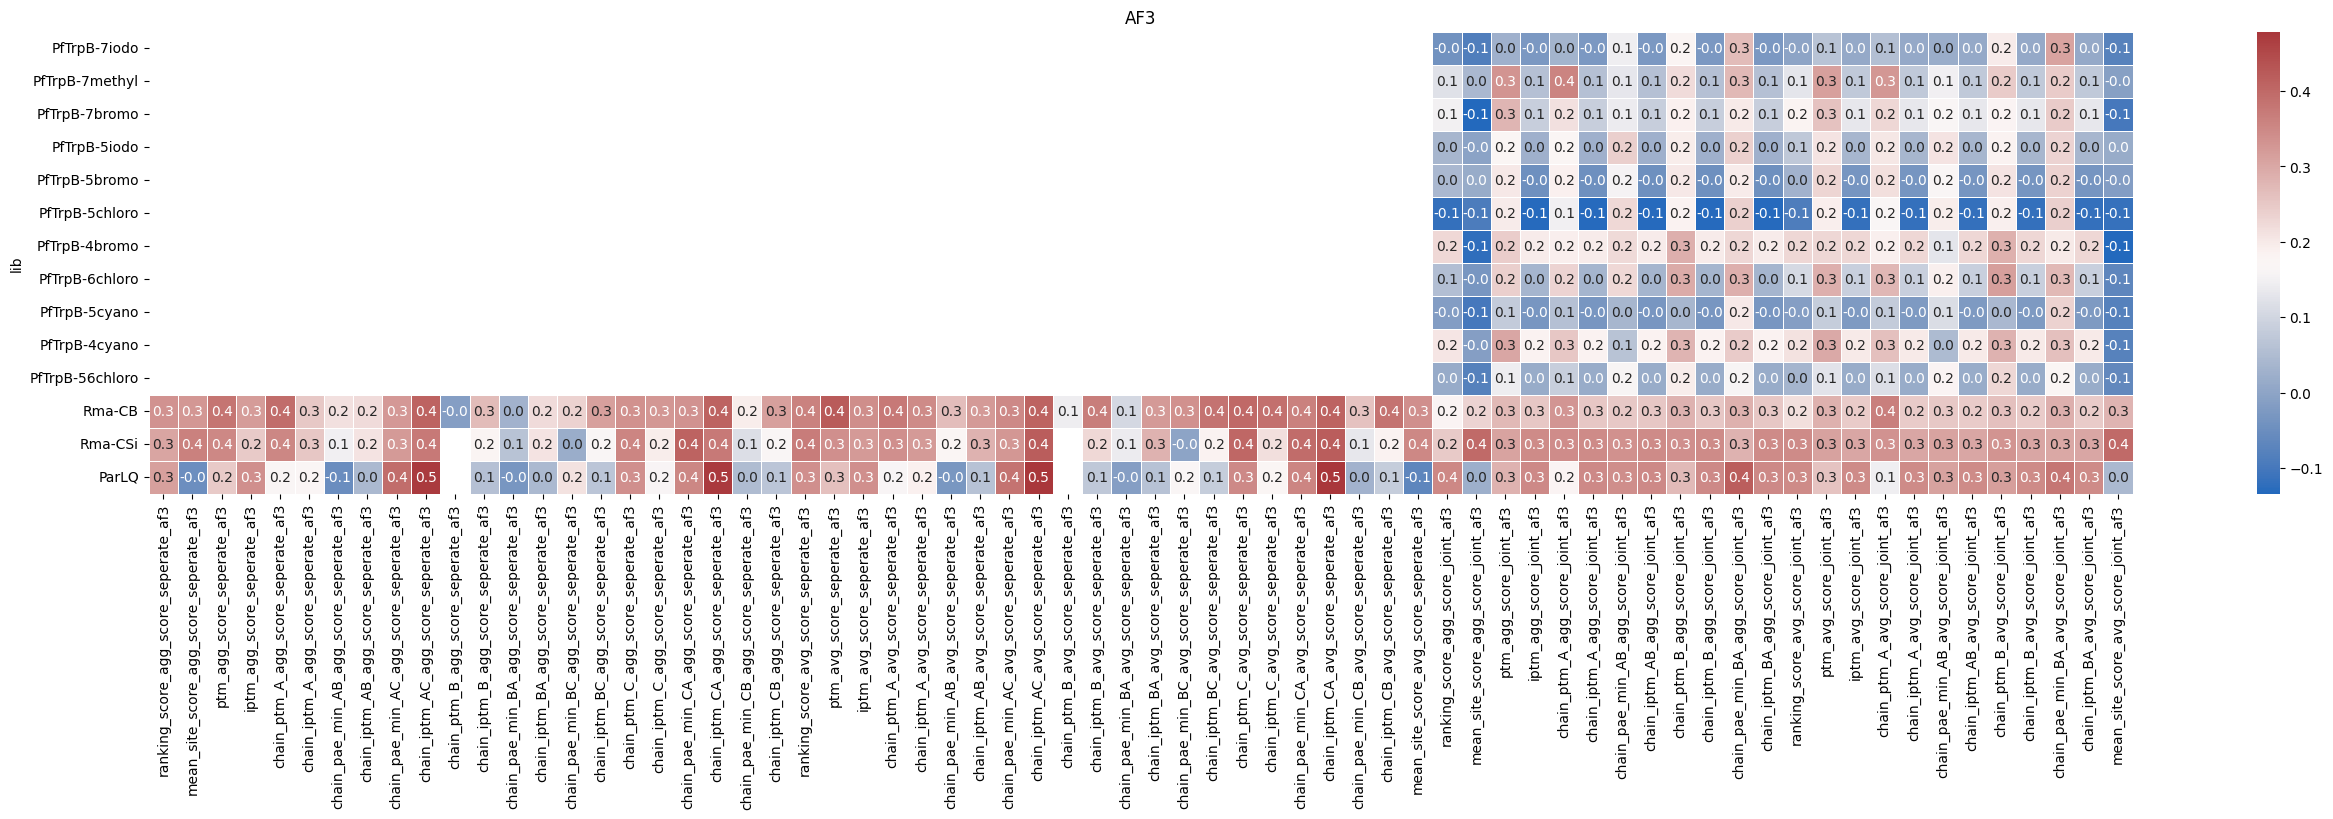

In [118]:
af3_df = (
    df_rho[
        [
            "lib",
            "ranking_score_agg_score_seperate_af3",
            "mean_site_score_agg_score_seperate_af3",
            "ptm_agg_score_seperate_af3",
            "iptm_agg_score_seperate_af3",
            # "fraction_disordered_agg_score_seperate_af3",
            "chain_ptm_A_agg_score_seperate_af3",
            "chain_iptm_A_agg_score_seperate_af3",
            "chain_pae_min_AB_agg_score_seperate_af3",
            "chain_iptm_AB_agg_score_seperate_af3",
            "chain_pae_min_AC_agg_score_seperate_af3",
            "chain_iptm_AC_agg_score_seperate_af3",
            "chain_ptm_B_agg_score_seperate_af3",
            "chain_iptm_B_agg_score_seperate_af3",
            "chain_pae_min_BA_agg_score_seperate_af3",
            "chain_iptm_BA_agg_score_seperate_af3",
            "chain_pae_min_BC_agg_score_seperate_af3",
            "chain_iptm_BC_agg_score_seperate_af3",
            "chain_ptm_C_agg_score_seperate_af3",
            "chain_iptm_C_agg_score_seperate_af3",
            "chain_pae_min_CA_agg_score_seperate_af3",
            "chain_iptm_CA_agg_score_seperate_af3",
            "chain_pae_min_CB_agg_score_seperate_af3",
            "chain_iptm_CB_agg_score_seperate_af3",
            "ranking_score_avg_score_seperate_af3",
            "ptm_avg_score_seperate_af3",
            "iptm_avg_score_seperate_af3",
            # "fraction_disordered_avg_score_seperate_af3",
            "chain_ptm_A_avg_score_seperate_af3",
            "chain_iptm_A_avg_score_seperate_af3",
            "chain_pae_min_AB_avg_score_seperate_af3",
            "chain_iptm_AB_avg_score_seperate_af3",
            "chain_pae_min_AC_avg_score_seperate_af3",
            "chain_iptm_AC_avg_score_seperate_af3",
            "chain_ptm_B_avg_score_seperate_af3",
            "chain_iptm_B_avg_score_seperate_af3",
            "chain_pae_min_BA_avg_score_seperate_af3",
            "chain_iptm_BA_avg_score_seperate_af3",
            "chain_pae_min_BC_avg_score_seperate_af3",
            "chain_iptm_BC_avg_score_seperate_af3",
            "chain_ptm_C_avg_score_seperate_af3",
            "chain_iptm_C_avg_score_seperate_af3",
            "chain_pae_min_CA_avg_score_seperate_af3",
            "chain_iptm_CA_avg_score_seperate_af3",
            "chain_pae_min_CB_avg_score_seperate_af3",
            "chain_iptm_CB_avg_score_seperate_af3",
            "mean_site_score_avg_score_seperate_af3",
            "ranking_score_agg_score_joint_af3",
            "mean_site_score_agg_score_joint_af3",
            "ptm_agg_score_joint_af3",
            "iptm_agg_score_joint_af3",
            # "fraction_disordered_agg_score_joint_af3",
            "chain_ptm_A_agg_score_joint_af3",
            "chain_iptm_A_agg_score_joint_af3",
            "chain_pae_min_AB_agg_score_joint_af3",
            "chain_iptm_AB_agg_score_joint_af3",
            "chain_ptm_B_agg_score_joint_af3",
            "chain_iptm_B_agg_score_joint_af3",
            "chain_pae_min_BA_agg_score_joint_af3",
            "chain_iptm_BA_agg_score_joint_af3",
            "ranking_score_avg_score_joint_af3",
            "ptm_avg_score_joint_af3",
            "iptm_avg_score_joint_af3",
            # "fraction_disordered_avg_score_joint_af3",
            "chain_ptm_A_avg_score_joint_af3",
            "chain_iptm_A_avg_score_joint_af3",
            "chain_pae_min_AB_avg_score_joint_af3",
            "chain_iptm_AB_avg_score_joint_af3",
            "chain_ptm_B_avg_score_joint_af3",
            "chain_iptm_B_avg_score_joint_af3",
            "chain_pae_min_BA_avg_score_joint_af3",
            "chain_iptm_BA_avg_score_joint_af3",
            "mean_site_score_avg_score_joint_af3",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(32, 6))

# Create a heatmap
sns.heatmap(af3_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("AF3")
plt.show()

In [140]:
af3_df.mean().sort_values(ascending=False)[:18]

chain_iptm_AC_avg_score_seperate_af3       0.436514
chain_iptm_CA_avg_score_seperate_af3       0.436514
chain_iptm_AC_agg_score_seperate_af3       0.418810
chain_iptm_CA_agg_score_seperate_af3       0.418810
chain_ptm_C_avg_score_seperate_af3         0.383702
chain_pae_min_CA_avg_score_seperate_af3    0.372001
chain_pae_min_CA_agg_score_seperate_af3    0.366229
ranking_score_avg_score_seperate_af3       0.355507
chain_pae_min_AC_avg_score_seperate_af3    0.353640
chain_pae_min_AC_agg_score_seperate_af3    0.346240
chain_ptm_C_agg_score_seperate_af3         0.343325
ptm_avg_score_seperate_af3                 0.341455
iptm_avg_score_seperate_af3                0.333925
ptm_agg_score_seperate_af3                 0.326257
ranking_score_agg_score_seperate_af3       0.316750
chain_ptm_A_agg_score_seperate_af3         0.304504
iptm_agg_score_seperate_af3                0.301812
chain_ptm_A_avg_score_seperate_af3         0.292070
dtype: float64

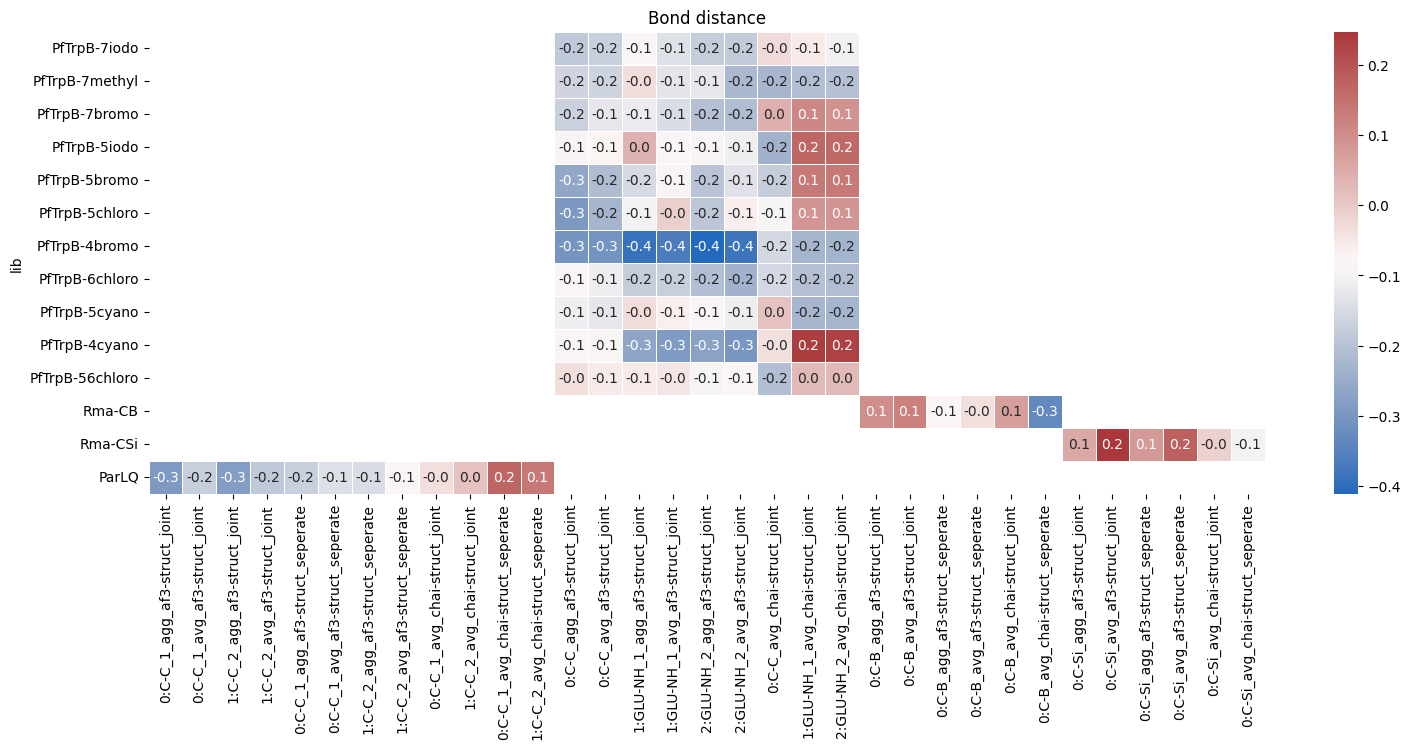

In [127]:
bond_df = (
    df_rho[
        [
            "lib",
            "0:C-C_1_agg_af3-struct_joint",
            "0:C-C_1_avg_af3-struct_joint",
            "1:C-C_2_agg_af3-struct_joint",
            "1:C-C_2_avg_af3-struct_joint",
            "0:C-C_1_agg_af3-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "1:C-C_2_agg_af3-struct_seperate",
            "1:C-C_2_avg_af3-struct_seperate",
            "0:C-C_1_avg_chai-struct_joint",
            "1:C-C_2_avg_chai-struct_joint",
            "0:C-C_1_avg_chai-struct_seperate",
            "1:C-C_2_avg_chai-struct_seperate",
            "0:C-C_agg_af3-struct_joint",
            "0:C-C_avg_af3-struct_joint",
            "1:GLU-NH_1_agg_af3-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "2:GLU-NH_2_agg_af3-struct_joint",
            "2:GLU-NH_2_avg_af3-struct_joint",
            "0:C-C_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "2:GLU-NH_2_avg_chai-struct_joint",
            "0:C-B_agg_af3-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "0:C-B_agg_af3-struct_seperate",
            "0:C-B_avg_af3-struct_seperate",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_chai-struct_seperate",
            "0:C-Si_agg_af3-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "0:C-Si_agg_af3-struct_seperate",
            "0:C-Si_avg_af3-struct_seperate",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_chai-struct_seperate",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(18, 6))

# Create a heatmap
sns.heatmap(bond_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Bond distance")
plt.show()

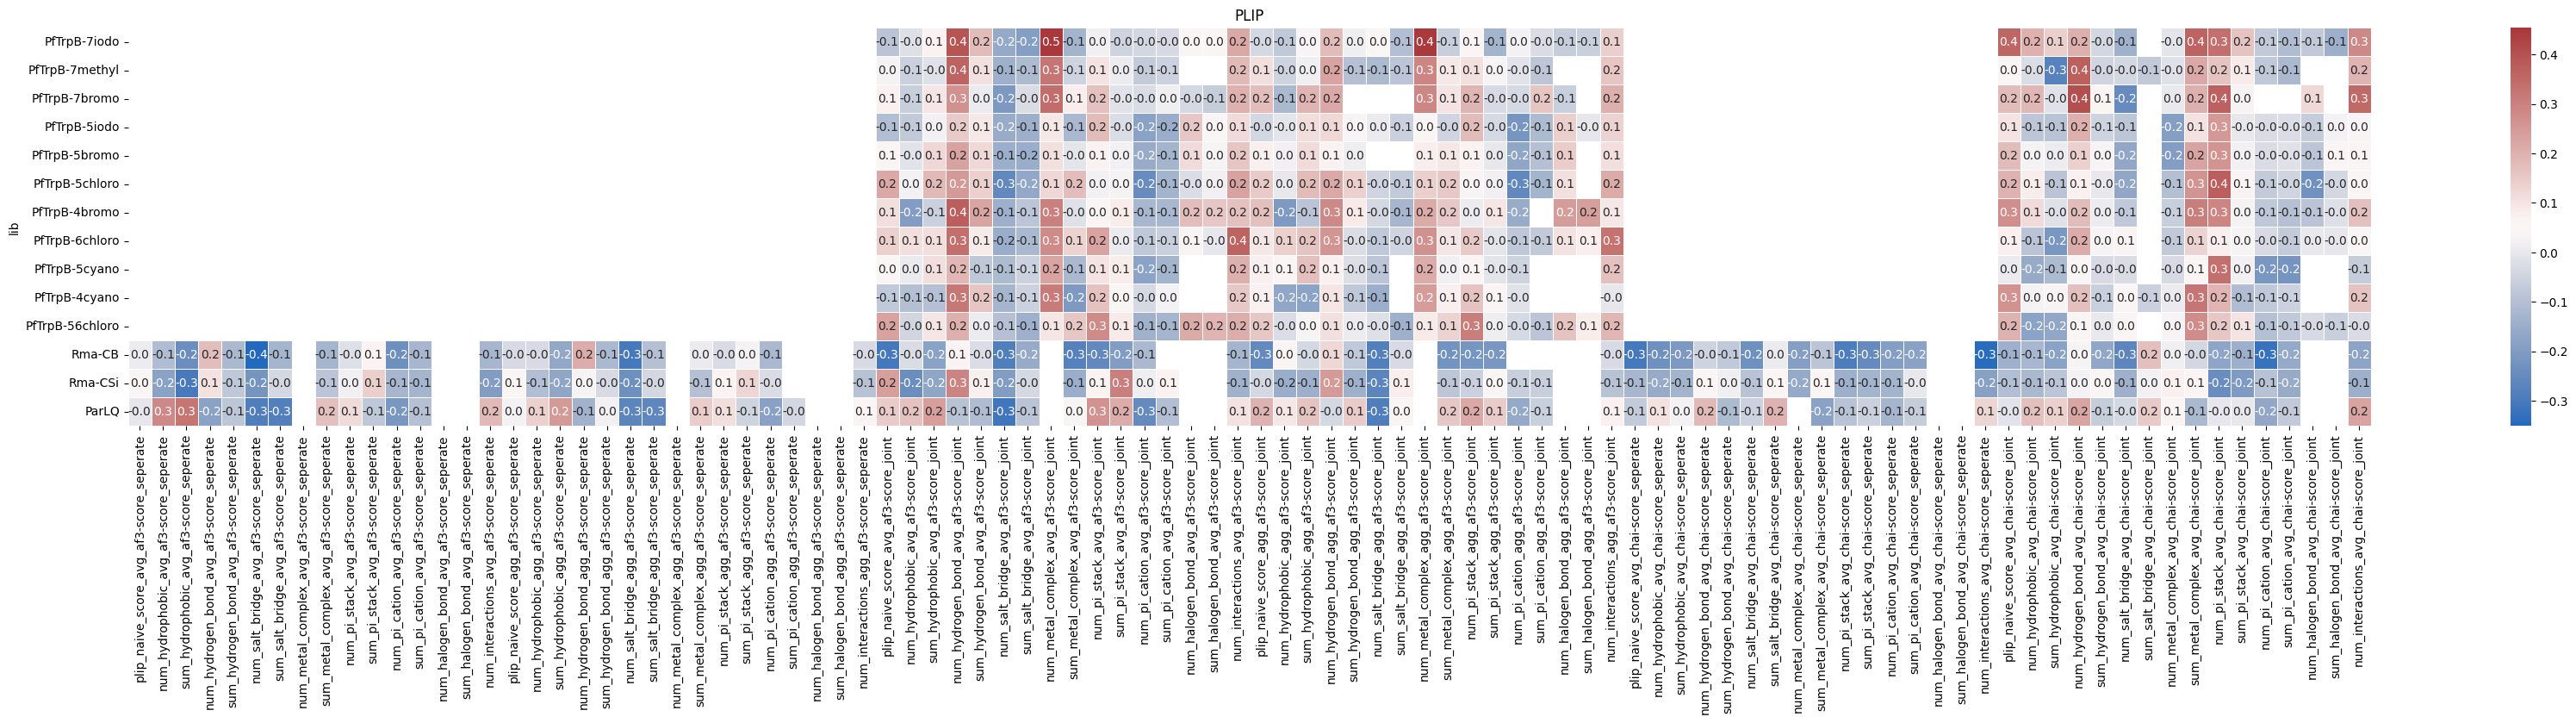

In [154]:
plip_metrics = [
    "lib",
    "plip_naive_score_avg_af3-score_seperate",
    "num_hydrophobic_avg_af3-score_seperate",
    "sum_hydrophobic_avg_af3-score_seperate",
    "num_hydrogen_bond_avg_af3-score_seperate",
    "sum_hydrogen_bond_avg_af3-score_seperate",
    "num_salt_bridge_avg_af3-score_seperate",
    "sum_salt_bridge_avg_af3-score_seperate",
    "num_metal_complex_avg_af3-score_seperate",
    "sum_metal_complex_avg_af3-score_seperate",
    "num_pi_stack_avg_af3-score_seperate",
    "sum_pi_stack_avg_af3-score_seperate",
    "num_pi_cation_avg_af3-score_seperate",
    "sum_pi_cation_avg_af3-score_seperate",
    "num_halogen_bond_avg_af3-score_seperate",
    "sum_halogen_bond_avg_af3-score_seperate",
    "num_interactions_avg_af3-score_seperate",
    "plip_naive_score_agg_af3-score_seperate",
    "num_hydrophobic_agg_af3-score_seperate",
    "sum_hydrophobic_agg_af3-score_seperate",
    "num_hydrogen_bond_agg_af3-score_seperate",
    "sum_hydrogen_bond_agg_af3-score_seperate",
    "num_salt_bridge_agg_af3-score_seperate",
    "sum_salt_bridge_agg_af3-score_seperate",
    "num_metal_complex_agg_af3-score_seperate",
    "sum_metal_complex_agg_af3-score_seperate",
    "num_pi_stack_agg_af3-score_seperate",
    "sum_pi_stack_agg_af3-score_seperate",
    "num_pi_cation_agg_af3-score_seperate",
    "sum_pi_cation_agg_af3-score_seperate",
    "num_halogen_bond_agg_af3-score_seperate",
    "sum_halogen_bond_agg_af3-score_seperate",
    "num_interactions_agg_af3-score_seperate",
    "plip_naive_score_avg_af3-score_joint",
    "num_hydrophobic_avg_af3-score_joint",
    "sum_hydrophobic_avg_af3-score_joint",
    "num_hydrogen_bond_avg_af3-score_joint",
    "sum_hydrogen_bond_avg_af3-score_joint",
    "num_salt_bridge_avg_af3-score_joint",
    "sum_salt_bridge_avg_af3-score_joint",
    "num_metal_complex_avg_af3-score_joint",
    "sum_metal_complex_avg_af3-score_joint",
    "num_pi_stack_avg_af3-score_joint",
    "sum_pi_stack_avg_af3-score_joint",
    "num_pi_cation_avg_af3-score_joint",
    "sum_pi_cation_avg_af3-score_joint",
    "num_halogen_bond_avg_af3-score_joint",
    "sum_halogen_bond_avg_af3-score_joint",
    "num_interactions_avg_af3-score_joint",
    "plip_naive_score_agg_af3-score_joint",
    "num_hydrophobic_agg_af3-score_joint",
    "sum_hydrophobic_agg_af3-score_joint",
    "num_hydrogen_bond_agg_af3-score_joint",
    "sum_hydrogen_bond_agg_af3-score_joint",
    "num_salt_bridge_agg_af3-score_joint",
    "sum_salt_bridge_agg_af3-score_joint",
    "num_metal_complex_agg_af3-score_joint",
    "sum_metal_complex_agg_af3-score_joint",
    "num_pi_stack_agg_af3-score_joint",
    "sum_pi_stack_agg_af3-score_joint",
    "num_pi_cation_agg_af3-score_joint",
    "sum_pi_cation_agg_af3-score_joint",
    "num_halogen_bond_agg_af3-score_joint",
    "sum_halogen_bond_agg_af3-score_joint",
    "num_interactions_agg_af3-score_joint",
    "plip_naive_score_avg_chai-score_seperate",
    "num_hydrophobic_avg_chai-score_seperate",
    "sum_hydrophobic_avg_chai-score_seperate",
    "num_hydrogen_bond_avg_chai-score_seperate",
    "sum_hydrogen_bond_avg_chai-score_seperate",
    "num_salt_bridge_avg_chai-score_seperate",
    "sum_salt_bridge_avg_chai-score_seperate",
    "num_metal_complex_avg_chai-score_seperate",
    "sum_metal_complex_avg_chai-score_seperate",
    "num_pi_stack_avg_chai-score_seperate",
    "sum_pi_stack_avg_chai-score_seperate",
    "num_pi_cation_avg_chai-score_seperate",
    "sum_pi_cation_avg_chai-score_seperate",
    "num_halogen_bond_avg_chai-score_seperate",
    "sum_halogen_bond_avg_chai-score_seperate",
    "num_interactions_avg_chai-score_seperate",
    "plip_naive_score_avg_chai-score_joint",
    "num_hydrophobic_avg_chai-score_joint",
    "sum_hydrophobic_avg_chai-score_joint",
    "num_hydrogen_bond_avg_chai-score_joint",
    "sum_hydrogen_bond_avg_chai-score_joint",
    "num_salt_bridge_avg_chai-score_joint",
    "sum_salt_bridge_avg_chai-score_joint",
    "num_metal_complex_avg_chai-score_joint",
    "sum_metal_complex_avg_chai-score_joint",
    "num_pi_stack_avg_chai-score_joint",
    "sum_pi_stack_avg_chai-score_joint",
    "num_pi_cation_avg_chai-score_joint",
    "sum_pi_cation_avg_chai-score_joint",
    "num_halogen_bond_avg_chai-score_joint",
    "sum_halogen_bond_avg_chai-score_joint",
    "num_interactions_avg_chai-score_joint"
]

plip_df = df_rho[plip_metrics].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(42, 6))

# Create a heatmap
sns.heatmap(plip_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("PLIP")
plt.show()

In [153]:
plip_df.mean().sort_values(ascending=False)[:16]

num_metal_complex_avg_af3-score_joint      0.242016
num_hydrogen_bond_avg_af3-score_joint      0.238973
num_metal_complex_agg_af3-score_joint      0.210913
num_pi_stack_avg_chai-score_joint          0.171691
sum_metal_complex_avg_chai-score_joint     0.169805
num_hydrogen_bond_avg_chai-score_joint     0.167127
num_hydrogen_bond_agg_af3-score_joint      0.156176
num_interactions_avg_af3-score_joint       0.146445
num_interactions_agg_af3-score_joint       0.120545
plip_naive_score_avg_chai-score_joint      0.115248
num_pi_stack_avg_af3-score_joint           0.103638
num_halogen_bond_agg_af3-score_joint       0.097520
num_pi_stack_agg_af3-score_joint           0.090524
num_halogen_bond_avg_af3-score_joint       0.089009
sum_salt_bridge_avg_chai-score_seperate    0.087643
num_interactions_avg_chai-score_joint      0.083275
dtype: float64

Text(0.5, 1.0, 'Vina')

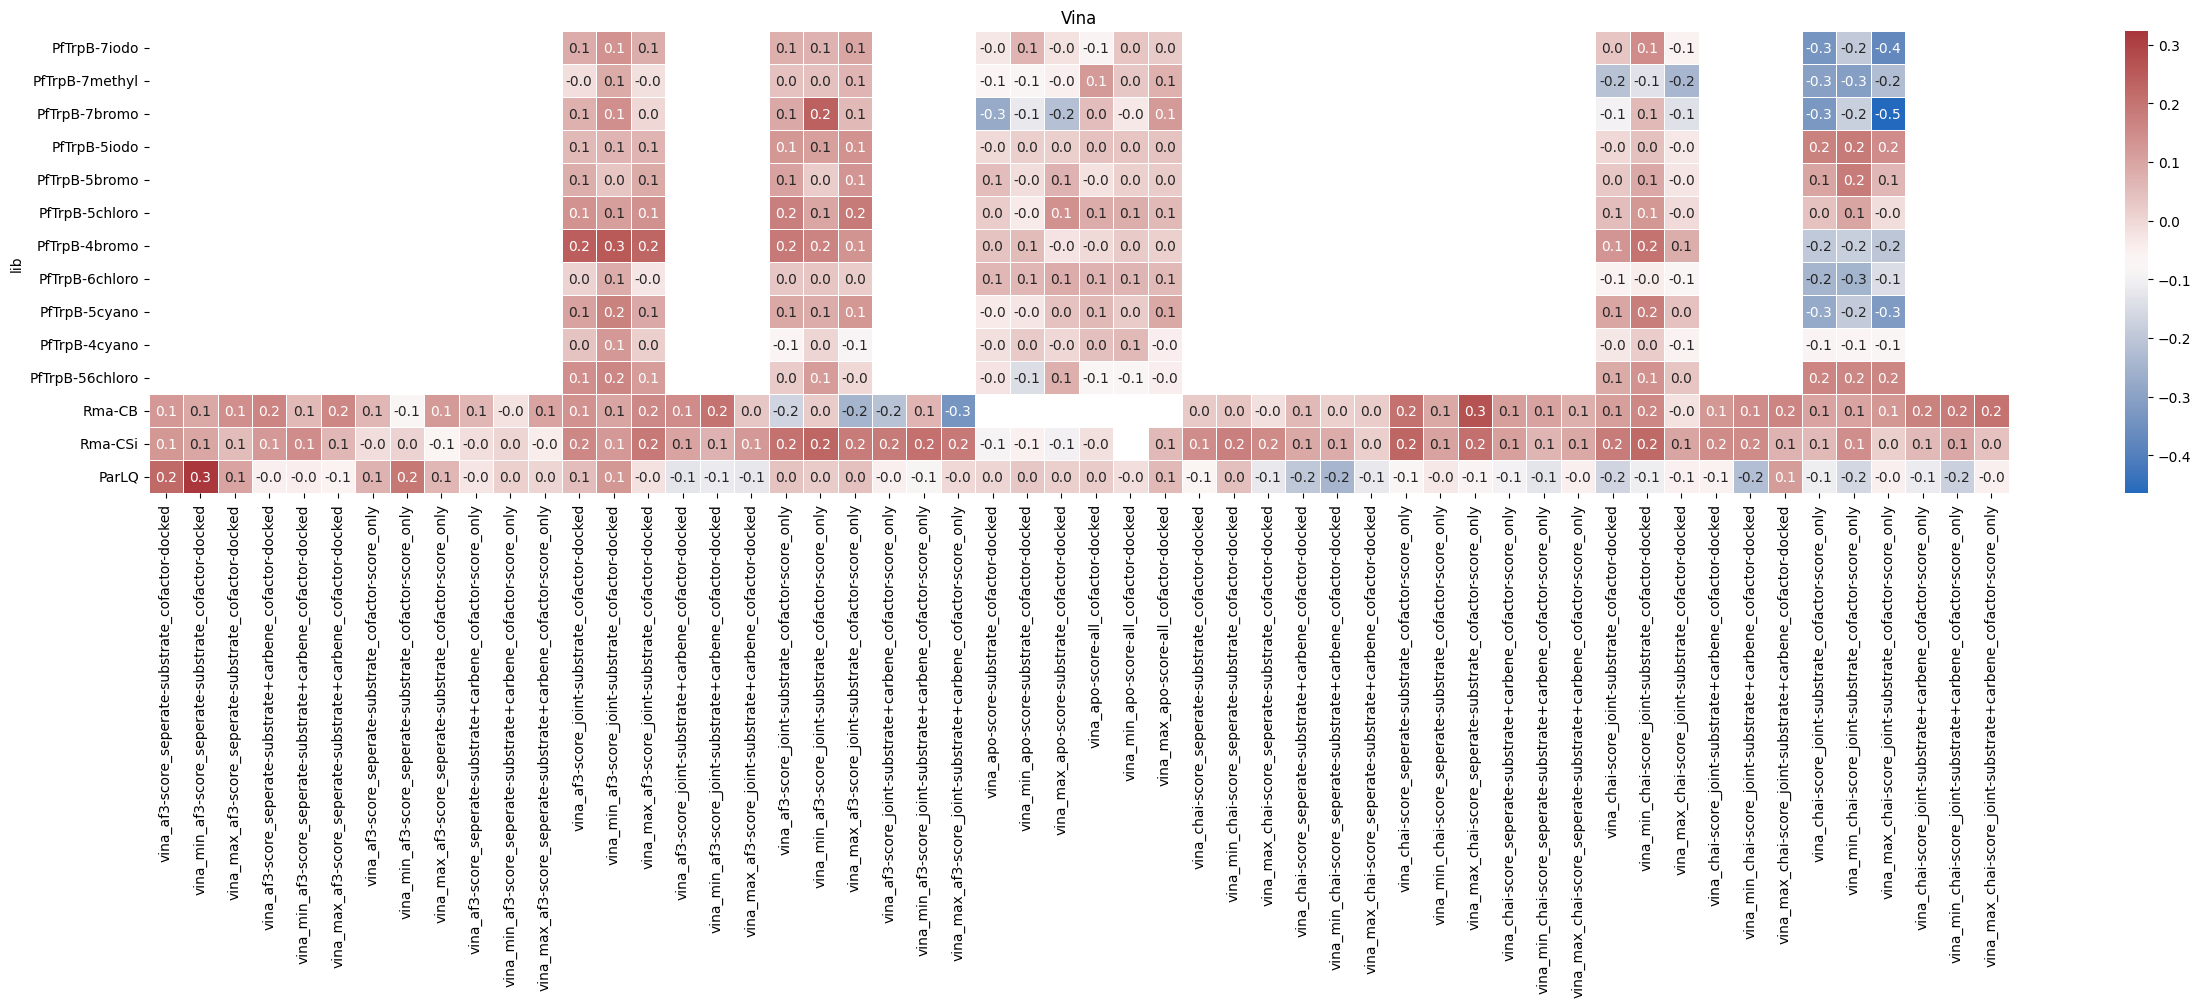

In [157]:
vina_cols = vina_scores = [
    "lib",
    "vina_af3-score_seperate-substrate_cofactor-docked",
    "vina_min_af3-score_seperate-substrate_cofactor-docked",
    "vina_max_af3-score_seperate-substrate_cofactor-docked",
    "vina_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_min_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_max_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_af3-score_seperate-substrate_cofactor-score_only",
    "vina_min_af3-score_seperate-substrate_cofactor-score_only",
    "vina_max_af3-score_seperate-substrate_cofactor-score_only",
    "vina_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_min_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_max_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_af3-score_joint-substrate_cofactor-docked",
    "vina_min_af3-score_joint-substrate_cofactor-docked",
    "vina_max_af3-score_joint-substrate_cofactor-docked",
    "vina_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_min_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_max_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_af3-score_joint-substrate_cofactor-score_only",
    "vina_min_af3-score_joint-substrate_cofactor-score_only",
    "vina_max_af3-score_joint-substrate_cofactor-score_only",
    "vina_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_min_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_max_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_apo-score-substrate_cofactor-docked",
    "vina_min_apo-score-substrate_cofactor-docked",
    "vina_max_apo-score-substrate_cofactor-docked",
    "vina_apo-score-all_cofactor-docked",
    "vina_min_apo-score-all_cofactor-docked",
    "vina_max_apo-score-all_cofactor-docked",
    "vina_chai-score_seperate-substrate_cofactor-docked",
    "vina_min_chai-score_seperate-substrate_cofactor-docked",
    "vina_max_chai-score_seperate-substrate_cofactor-docked",
    "vina_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_min_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_max_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_chai-score_seperate-substrate_cofactor-score_only",
    "vina_min_chai-score_seperate-substrate_cofactor-score_only",
    "vina_max_chai-score_seperate-substrate_cofactor-score_only",
    "vina_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_min_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_max_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_chai-score_joint-substrate_cofactor-docked",
    "vina_min_chai-score_joint-substrate_cofactor-docked",
    "vina_max_chai-score_joint-substrate_cofactor-docked",
    "vina_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_min_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_max_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_chai-score_joint-substrate_cofactor-score_only",
    "vina_min_chai-score_joint-substrate_cofactor-score_only",
    "vina_max_chai-score_joint-substrate_cofactor-score_only",
    "vina_chai-score_joint-substrate+carbene_cofactor-score_only",
    "vina_min_chai-score_joint-substrate+carbene_cofactor-score_only",
    "vina_max_chai-score_joint-substrate+carbene_cofactor-score_only"
]
vina_df = df_rho[vina_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(30, 6))
# Create a heatmap
sns.heatmap(vina_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Vina")

In [158]:
vina_df.mean().sort_values(ascending=False)[:16]

vina_min_af3-score_seperate-substrate_cofactor-docked              0.171387
vina_af3-score_seperate-substrate_cofactor-docked                  0.156145
vina_max_chai-score_seperate-substrate_cofactor-score_only         0.138852
vina_min_af3-score_joint-substrate_cofactor-docked                 0.122953
vina_chai-score_seperate-substrate_cofactor-score_only             0.120055
vina_max_chai-score_joint-substrate+carbene_cofactor-docked        0.117822
vina_max_af3-score_seperate-substrate_cofactor-docked              0.099351
vina_af3-score_joint-substrate_cofactor-docked                     0.093570
vina_min_af3-score_joint-substrate_cofactor-score_only             0.090033
vina_min_chai-score_seperate-substrate_cofactor-docked             0.085811
vina_af3-score_seperate-substrate+carbene_cofactor-docked          0.081092
vina_max_af3-score_joint-substrate_cofactor-docked                 0.079557
vina_min_chai-score_joint-substrate_cofactor-docked                0.078332
vina_chai-sc

In [19]:
custom_order[:10]

['PfTrpB-7iodo',
 'PfTrpB-7methyl',
 'PfTrpB-7bromo',
 'PfTrpB-5iodo',
 'PfTrpB-5bromo',
 'PfTrpB-5chloro',
 'PfTrpB-4bromo',
 'PfTrpB-6chloro',
 'PfTrpB-5cyano',
 'PfTrpB-4cyano']

In [21]:
trpb_rho_df = df_rho[df_rho["lib"].isin(custom_order[:10])].set_index("lib").reindex(custom_order[:10])
trpb_rho_df

,selectivity,n_mut,hd,ev_score,esm_score,flowsite_score,flowsite_std,ligandmpnn_score,var_vol,substrate_vol,...,0:C-Si_agg_af3-struct_joint,0:C-Si_avg_af3-struct_joint,0:C-Si_std_af3-struct_joint,0:C-Si_agg_af3-struct_seperate,0:C-Si_avg_af3-struct_seperate,0:C-Si_std_af3-struct_seperate,0:C-Si_avg_chai-struct_joint,0:C-Si_std_chai-struct_joint,0:C-Si_avg_chai-struct_seperate,0:C-Si_std_chai-struct_seperate
lib,,,,,,,,,,,,,,,,,,,,,
PfTrpB-7iodo,NaN,-0.369552,0.369552,0.493195,0.548700,0.433207,0.207595,0.523829,-0.138034,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PfTrpB-7methyl,NaN,-0.390165,0.390165,0.498362,0.561501,0.376550,0.162809,0.495413,-0.023272,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PfTrpB-7bromo,NaN,-0.324373,0.324373,0.539337,0.610375,0.406268,0.284918,0.488873,-0.106789,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PfTrpB-5iodo,NaN,-0.268085,0.268085,0.419296,0.479928,0.426583,0.234349,0.428536,0.137772,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PfTrpB-5bromo,NaN,-0.331510,0.331510,0.487423,0.523450,0.404282,0.289631,0.462262,0.025118,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PfTrpB-5chloro,NaN,-0.387294,0.387294,0.521059,0.582487,0.375597,0.267212,0.517904,-0.001552,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PfTrpB-4bromo,NaN,-0.371285,0.371285,0.474594,0.478416,0.415240,0.212191,0.522690,-0.177474,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PfTrpB-6chloro,NaN,-0.417893,0.417893,0.569694,0.612678,0.457337,0.241263,0.576349,-0.055604,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PfTrpB-5cyano,NaN,-0.301809,0.301809,0.396476,0.425708,0.382270,0.268198,0.440015,-0.042512,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'ZS Summary: Spearman correlation')

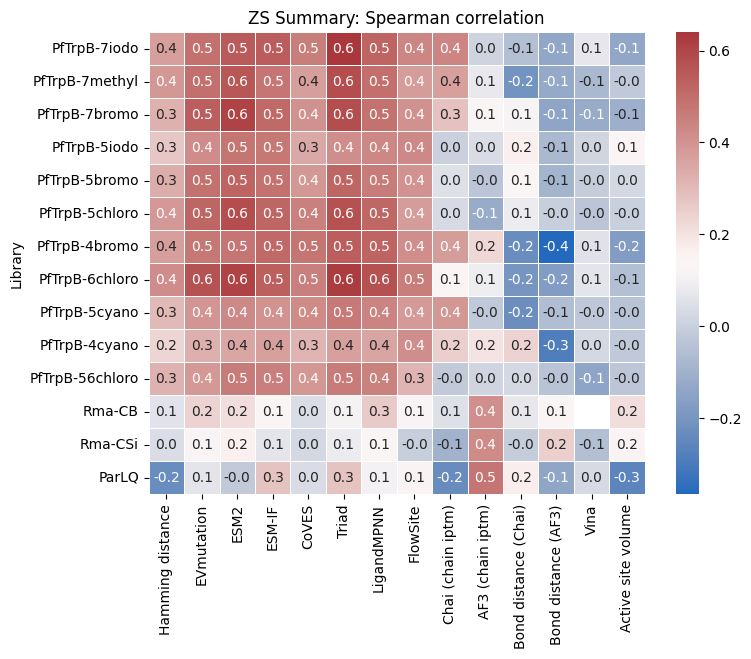

In [52]:
trpb_rho_df = df_rho[df_rho["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_rho[df_rho["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_rho[df_rho["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_rho[df_rho["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: Spearman correlation")

Text(0.5, 1.0, 'ZS Summary: NDCG')

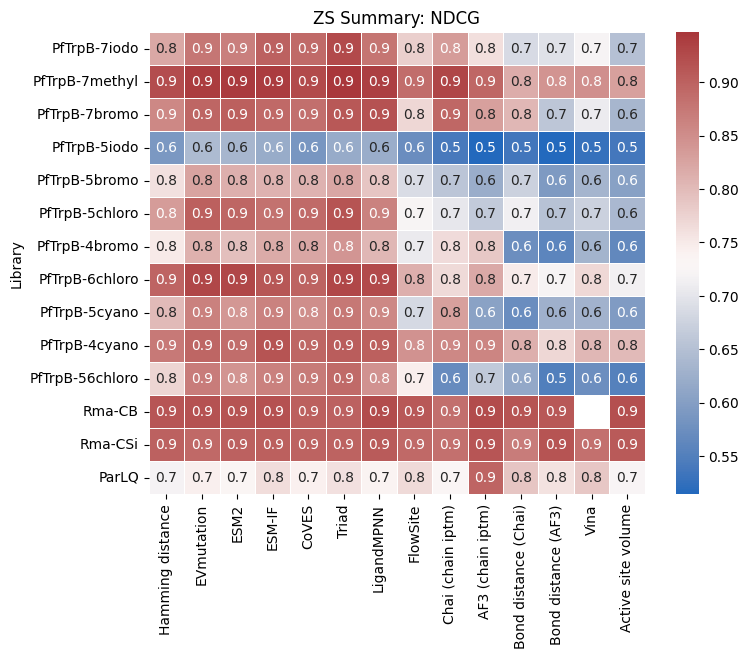

In [53]:
trpb_rho_df = df_ndcg[df_ndcg["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_ndcg[df_ndcg["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_ndcg[df_ndcg["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_ndcg[df_ndcg["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: NDCG")

Text(0.5, 1.0, 'ZS Summary: Top 10% recall')

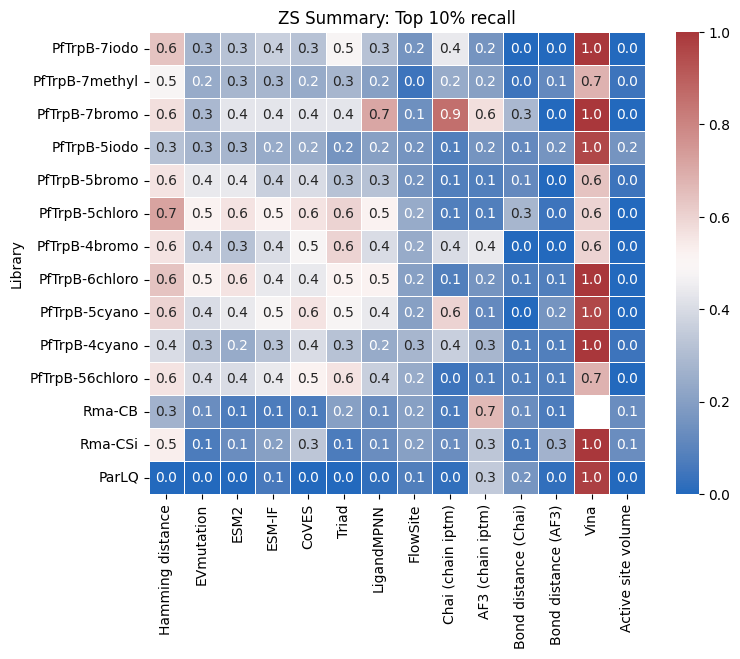

In [54]:
trpb_rho_df = df_top10[df_top10["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_top10[df_top10["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_top10[df_top10["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top10[df_top10["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: Top 10% recall")